### This script is to validate the appropriate number of coherent domains from the result of diffusion map calculation, then perform a hierarchical clustering in the diffusion space to obtain the coherent domains.

In [1]:
%pylab inline
%config InlineBackend.figure_format='svg'
import sympy
import sys
import random
import math
import scipy
import os
import time
import matplotlib.pyplot as plt
from itertools import product 
from scipy.cluster import hierarchy 
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import AgglomerativeClustering as AgCl
from sklearn.cluster import DBSCAN as DBSCAN
from sklearn.cluster.hierarchical import ward_tree 
from sklearn.cluster.hierarchical import linkage_tree

Populating the interactive namespace from numpy and matplotlib


In [2]:
def ag_clustering(X, n_clusters):
    
    model_ward = AgCl(n_clusters=n_clusters, linkage='ward', affinity='euclidean')
    model_ward.fit(X)

    #model_linkage = AgCl(n_clusters=n_clusters, linkage='average', affinity='euclidean')
    #model_linkage.fit(X)

    tree_ward = ward_tree(X, return_distance=True)
    #tree_linkage = linkage_tree(X, linkage='average', affinity='euclidean', return_distance=True)

    #return model_ward, tree_ward, model_linkage, tree_linkage
    return model_ward, tree_ward

In [3]:
def clust_dist(idx_a, na, idx_b, nb, idx_v, nv, dX):
    # a and b are clusters newly joined to compose new cluster
    # idx_a and idx_b are indexes of clusters a and b, respectively
    # na and nb are number of elements of clusters a and b, respectively
    # v is separate cluster, with index idx_v, and nv elements 
    # dX is previous distance matrix between every pair of clusters
    
    T = float(na + nb + nv)
    dist = (float(na+nv)/T)*dX[idx_a,idx_v]**2 + (float(nb+nv)/T)*dX[idx_b,idx_v]**2 - \
           (float(nv)/T)*dX[idx_a,idx_b]**2
    
    return np.sqrt(dist)
    

In [4]:
def clustering_ward_metric(X):
    tol = 1e-12

    tree_ward = ward_tree(X, return_distance=True)

    card_all = []
    cluster_indexes_all = []
    dX_min = []
    dA_all = []
    dX_all = []
    silhouette = []
     
    #print('zeroth step: euclidean distances')
    
    cluster_indexes = np.arange(np.shape(X)[0]).astype(int)
    card = np.zeros(2*np.shape(X)[0]).astype(int)
    card[cluster_indexes] = 1
    
    cluster_indexes_all.append(cluster_indexes)
    card_all.append(card)
    
    dA0 = np.zeros(np.shape(cluster_indexes)[0])
    dX0 = np.zeros((2*np.shape(cluster_indexes)[0], 2*np.shape(cluster_indexes)[0]))
    for i in range(np.shape(cluster_indexes)[0]-1):
        for j in range(i+1,np.shape(cluster_indexes)[0]):
            dX0[i,j] = np.sqrt(np.sum((X[i,:]-X[j,:])**2))
            dX0[j,i] = dX0[i,j]

    dX_all.append(dX0)
    dA_all.append(dA0)
    
    dA_old = dA0
    cluster_indexes_old = cluster_indexes
    
    dX0_min = np.zeros(np.shape(cluster_indexes)[0])
    for j, idx in enumerate(cluster_indexes):
        other_indexes = list(set(cluster_indexes) - set([idx]))
        dX0_min[j] = np.min(dX0[idx,other_indexes])
    dX_min.append(dX0_min)
    
    #print(np.min(dX0_min), tree_ward[4][0])
    #print(np.min(dA0))
    
    s = np.zeros(len(cluster_indexes))
    
    for j in range(len(cluster_indexes)): 
        ABmax = max(dA0[j],dX0_min[j])
        s[j] = (dX0_min[j] - dA0[j] )/ABmax 
            
    silhouette.append(s)
    
    #print('start clustering: use ward distance between clusters')
    for k in range(tree_ward[2]-2):
    
        new_idx = tree_ward[2]+k
        idx_1 = tree_ward[0][k][0]
        idx_2= tree_ward[0][k][1]
    
        card[new_idx] = card[idx_1] + card[idx_2]
        joined_clusters = set(tree_ward[0][k])
        cluster_indexes = list(set(cluster_indexes) - joined_clusters) 
        
        dX = dX0
        for idx in list(cluster_indexes): 
            dX[new_idx, idx] = clust_dist(idx_1, card[idx_1], idx_2, card[idx_2], idx, card[idx], dX0)
            dX[idx, new_idx] = dX[new_idx, idx]
        
        #print(idx_1, idx_2, dX0[idx_1,idx_2])
        dX0_tmp = dX0[idx_1,idx_2]
        
        dX[:, idx_2] = 0.
        dX[:, idx_1] = 0.
        dX[idx_1, :] = 0.
        dX[idx_2, :] = 0.
    
        dX_all.append(dX)
        
        if abs(np.min(dX[np.where(dX > 0.)]) - tree_ward[4][k+1]) > tol:
            print(np.min(dX[np.where(dX > 0.)]))  
            print(np.where(dX == np.min(dX[np.where(dX > 0.)]))) 
            print(tree_ward[4][k+1])
        
        assert abs(np.min(dX[np.where(dX > 0.)]) - tree_ward[4][k+1]) < tol

        if abs(np.min(dX_all[k+1][np.where(dX_all[k+1] > 0.)]) - tree_ward[4][k+1]) > tol:
            print(np.min(dX_all[k+1][np.where(dX_all[k+1] > 0.)]))  
            print(np.where(dX_all[k+1] == np.min(dX_all[k+1][np.where(dX_all[k+1] > 0.)]))) 
            print(tree_ward[4][k+1])
    
        assert abs(np.min(dX_all[k+1][np.where(dX_all[k+1] > 0.)]) - tree_ward[4][k+1]) < tol
    
        cluster_indexes = list(cluster_indexes) + [tree_ward[2]+k]
    
        cluster_indexes_all.append(cluster_indexes)
        card_all.append(card)
        
        dA = np.zeros(np.shape(cluster_indexes)[0])
        for j, idx in enumerate(cluster_indexes_old):
            kdx = np.where(np.array(cluster_indexes) == idx)[0]
            dA[kdx] = dA_old[j]
            
        jdx = np.where(np.array(cluster_indexes) == new_idx)[0]
        dA[jdx] = dX0_tmp
        
        """
        print('updating dA')
        print('size of cluster_indexes array: '+str(len(cluster_indexes)))
        print('index of new cluster: '+str(jdx))
        print('new cluster: '+str(new_idx))
        print('merged elements: '+str(idx_1)+' '+str(idx_2))
        print('distance between merged elements: '+str(dX0_tmp))
        """
        
        dX0 = dX
        
        """
        print('dA')
        print('shape of dA: '+str(np.shape(dA)))
        zeros = np.where(dA == 0)[0]
        nonzeros = np.where(dA > 0)[0]
        
        print('zeros')
        print('shape of zeros: '+str(np.shape(zeros)))
        print('zero elements: '+ str(np.array(cluster_indexes)[zeros]))
        
        print('nonzeros')
        print('shape of nonzeros: '+str(np.shape(nonzeros)))
        print('nonzeros elements: '+str(np.array(cluster_indexes)[nonzeros]))
        """
        
        dA_all.append(dA)
        
        dX0_min = np.zeros(np.shape(cluster_indexes)[0])
        for j, idx in enumerate(cluster_indexes):
            other_indexes = list(set(cluster_indexes) - set([idx]))
            dX0_min[j] = np.min(dX[idx,other_indexes])
        dX_min.append(dX0_min)
        
        """
        print('k = '+str(k))
        print('dX0_min :'+ str(np.min(dX0_min))+' '+str(tree_ward[4][k+1]))
        print('min dA = '+str(np.min(dA)))
        """
        
        s = np.zeros(len(cluster_indexes))
        
        for j in range(len(cluster_indexes)): 
            ABmax = max(dA[j], dX0_min[j])
            s[j] = (dX0_min[j] - dA[j] )/ABmax
            
        silhouette.append(s)
        dA_old = dA
        cluster_indexes_old = cluster_indexes
        
        #print(cluster_indexes_old[-1], cluster_indexes[-1])
        #print(dA_old[-1], dA[-1])
        
    return(dX_all, cluster_indexes, card, dX_min, dA_all, silhouette)

In [5]:
def plot_results(filename, neigen, idx_max_eps, nmax, Median = True, Mean = False, Min = False):
    
    import matplotlib.gridspec as gridspec
    
    fig = figure(figsize=(6,12))
    colrs = ['purple','blue', 'green', 'red', 'orange', 'yellow']
    
    G = gridspec.GridSpec(16, 1)
    ax1 = subplot(G[ :5, :])
    ax2 = subplot(G[6:11, :])
    ax3 = subplot(G[11: , :])
    
    npzfile = np.load(filename)
    #print(npzfile.keys())
    eigenvectors = npzfile['eigenvectors']
    epsilon = npzfile['epsilon']
    eigenvalues = npzfile['lambdas']
    
    ll = np.zeros(np.shape(eigenvalues))

    neigen_max = np.zeros(np.shape(eigenvalues)[0]).astype(int)
    for i in range(np.shape(epsilon)[0]):
        ll[i,:] = -epsilon[i]/log(real(eigenvalues[i,:]))
    
        nn = np.where(ll[i,:] > epsilon[i])[0]
        neigen_max[i] = np.shape(nn)[0]
    
    for j in range(idx_max_eps):
        eps_idx = j
        #neigen = min(neigen, neigen_max[eps_idx])
        
        X = real(eigenvectors[eps_idx,:,1:neigen])
        dX_all, cluster_indexes, card, dX_min, dA_all, Q = clustering_ward_metric(X)
        tree_ward = ward_tree(X, return_distance=True)   
        
        score = []
        score1 = []
        score2 = []
        for sil in Q:
            score.append(np.median(np.array(sil))) 
            score1.append(np.mean(np.array(sil))) 
            score2.append(np.min(np.array(sil)))
            
        score.append(-1.)
        score1.append(-1.)
        score2.append(-1.)
        
        #ax = fig.add_subplot(3,1,1)
        ax1.scatter(np.arange(np.shape(ll[j,1:])[0])+1, ll[j,1:], color = colrs[j])
        ax1.plot(np.arange(0,60+1,1)*0.+neigen-0.5, np.arange(0,60+1,1), \
                linestyle = '--', color ='red', linewidth=2)
    
        ax1.axis((0.,nmax, np.min(ll[:,1:])*0.01, np.max(ll[:,1:])*1.2))
        
        major_xticks = np.arange(0, nmax+1, 1)
        ax1.set_xticks(major_xticks)
        ax1.tick_params(labelsize=12)
        ax1.set_ylabel('$-\epsilon/\ln{\, \lambda_i}$', size=18)
        ax1.set_xlabel('Eigenvalue number, i', size=15)
    
        ax1.annotate('# non-trivial eigenvectors used = '+str(neigen-1), \
                    xy=(0.5, 1.05), xycoords='axes fraction', \
                    horizontalalignment='center', verticalalignment='center', \
                    fontsize = 15, color = 'crimson')
        ax1.annotate('$\epsilon$ = '+str(epsilon[j]), xy=(0.45, 0.7-j*0.09), \
                    xycoords='axes fraction', horizontalalignment='left', \
                    verticalalignment='center', fontsize = 18, color = colrs[j])
    
        for idx in range(nmax):
            ax1.plot(np.arange(0,60+1,1)*0.+idx, np.arange(0,60+1,1), \
                    color = 'gray', linewidth=0.1, linestyle ='--')
    
        print('epsilon = ' +str(epsilon[eps_idx]))
        print('eigenvectors below the treshold = ' +str(neigen_max[eps_idx]))

        #ax = fig.add_subplot(3,1,2)
        ax2.scatter(np.shape(tree_ward[4])[0] - np.arange(np.shape(tree_ward[4])[0]), tree_ward[4], \
                   linewidth = 0, color= colrs[j], s = 50, label = '$\epsilon = '+str(epsilon[j]))
    
        for idx in range(nmax):
            ax2.plot(np.arange(0,nmax+1,1)*0.+idx, np.arange(0,nmax+1,1), \
                    color = 'gray', linewidth=0.1, linestyle ='--')

        ax2.plot(np.arange(0,nmax+1,1)*0.+neigen-0.5, np.arange(0,nmax+1,1), \
                linestyle = '--', color ='red', linewidth=2)
    
        ymax = np.max(tree_ward[4])*1.1
        ax2.axis((0.,nmax,0.,ymax))
        ax2.tick_params(labelsize=12, labelbottom='off')
        ax2.set_ylabel('Distance treshold',size=15)

        
        #ax = fig.add_subplot(3,1,3)
        if Median:
            ax3.scatter(range(1,len(score)+1), score[::-1], s = 50, color = colrs[j], marker = 'o')
            ax3.plot(range(1,len(score)+1), score[::-1], color ='black', linewidth=0.9)
            print('max silhouette score for # clusters = '\
                  +str(np.argmax(score[::-1][:nmax])+1)+' ('+str(np.max(score[::-1][:nmax]))+')')
    
        if Mean:
            ax3.scatter(range(1,len(score1)+1), score1[::-1], s = 50, color = colrs[j], marker=(5, 2))
            ax3.plot(range(1,len(score1)+1), score1[::-1], color = 'gray', linewidth=0.9)
            print('max silhouette score for # clusters = '\
                  +str(np.argmax(score1[::-1][:nmax])+1)+' ('+str(np.max(score1[::-1][:nmax]))+')')
            
        if Min:
            ax3.scatter(range(1,len(score2)+1), score2[::-1], s = 50, color = colrs[j], marker=(5, 2))
            ax3.plot(range(1,len(score2)+1), score2[::-1], color = 'gray', linewidth=0.9)
            print('max silhouette score for # clusters = '\
                  +str(np.argmax(score2[::-1][:nmax])+1)+' ('+str(np.max(score2[::-1][:nmax]))+')')
            
        if (Mean & Median):
            ax3.scatter([0.42*nmax], [0.9-j*0.09], s = 50, color = colrs[j], marker='o')
            ax3.annotate('Median score', xy=(0.45, 0.9-j*0.09), xycoords='axes fraction', \
                        horizontalalignment='left', verticalalignment='center', \
                        fontsize = 18, color = colrs[j])
    
            ax3.scatter([0.42*nmax], [0.35-j*0.09], s = 50, color = colrs[j], marker=(5, 2))
            ax3.annotate('Mean score', xy=(0.45, 0.35-j*0.09), xycoords='axes fraction', \
                        horizontalalignment='left', verticalalignment='center', \
                        fontsize = 18, color = colrs[j])
    
        if (Median & Min):
            ax3.scatter([1.02*nmax], [0.9-j*0.09], s = 50, color = colrs[j], marker='o')
            ax3.annotate('Median score', xy=(1.05, 0.9-j*0.09), xycoords='axes fraction', \
                        horizontalalignment='left', verticalalignment='center', \
                        fontsize = 18, color = colrs[j])
    
            ax3.scatter([1.02*nmax], [0.35-j*0.09], s = 50, color = colrs[j], marker=(5, 2))
            ax3.annotate('Min score', xy=(1.05, 0.35-j*0.09), xycoords='axes fraction', \
                        horizontalalignment='left', verticalalignment='center', \
                        fontsize = 18, color = colrs[j])
            
        if (Mean & Min):
            ax3.scatter([1.02*nmax], [0.9-j*0.09], s = 50, color = colrs[j], marker='o')
            ax3.annotate('Mean score', xy=(1.05, 0.9-j*0.09), xycoords='axes fraction', \
                        horizontalalignment='left', verticalalignment='center', \
                        fontsize = 18, color = colrs[j])
    
            ax3.scatter([1.02*nmax], [0.35-j*0.09], s = 50, color = colrs[j], marker=(5, 2))
            ax3.annotate('Min score', xy=(1.05, 0.35-j*0.09), xycoords='axes fraction', \
                        horizontalalignment='left', verticalalignment='center', \
                        fontsize = 18, color = colrs[j])
    
        for idx in range(nmax):
            ax3.plot(np.arange(0,nmax+1,1)*0.+idx, np.arange(0,nmax+1,1), \
                    color = 'gray', linewidth=0.1, linestyle ='--')
        
        ax3.plot(np.arange(0,nmax+1,1)*0.+neigen-0.5, np.arange(0,nmax+1,1), \
                linestyle = '--', color ='red', linewidth=2)
    
        major_xticks = np.arange(0, nmax+1, 1)
        ax3.set_xticks(major_xticks)
        ax3.tick_params(labelsize=12)
        ax3.set_xlabel('Number of clusters', size=15)
        ax3.set_ylabel('Silhouette score', size=15)
        ax3.axis((0.,nmax,0.,0.99))

    fig.subplots_adjust(wspace=0, hspace=0)
    
    return

# Simulation under 0M urea

In [6]:
npzfile = np.load('ACTR_0_Sptdmap.npz')
print(npzfile.keys())
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']
#print(np.shape(eigenvectors))
#print(np.shape(epsilon))
#print(np.shape(eigenvalues))

print(epsilon)
print(real(eigenvalues[:,:20]))

['epsilon', 'lambdas', 'eigenvectors']
[0.2 0.3 0.4 0.5 0.6]
[[1.         0.95105801 0.92536064 0.8845589  0.86928342 0.84365179
  0.81294849 0.76861838 0.75227885 0.71711141 0.66234762 0.6608105
  0.61668977 0.57788081 0.53758123 0.51453638 0.47872136 0.46276805
  0.42069342 0.40805678]
 [1.         0.92625242 0.88885097 0.82673289 0.80176202 0.77246543
  0.72803474 0.66325314 0.63873611 0.59460337 0.52936728 0.51976911
  0.4675075  0.42303087 0.37604193 0.35337205 0.31653384 0.29748118
  0.25887782 0.24739032]
 [1.         0.90299936 0.85522307 0.77372864 0.73900447 0.71216537
  0.6526497  0.57358597 0.54263579 0.49357723 0.4261286  0.40863401
  0.35683729 0.3121222  0.26690072 0.24717798 0.21422548 0.19590144
  0.16440408 0.15446877]
 [1.         0.88124845 0.82402157 0.72539381 0.68093184 0.6605297
  0.58532827 0.49727924 0.46181164 0.4106238  0.34535404 0.32245108
  0.27456    0.2327285  0.19266702 0.17639577 0.1483989  0.13244862
  0.10784693 0.09982257]
 [1.         0.86088657 0

epsilon = 0.2
eigenvectors below the treshold = 19
max silhouette score for # clusters = 3 (0.6944308125754175)


/Users/wangfeiyang/miniconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


epsilon = 0.3
eigenvectors below the treshold = 15
max silhouette score for # clusters = 3 (0.7039119181295759)
epsilon = 0.4
eigenvectors below the treshold = 11
max silhouette score for # clusters = 3 (0.7139408129641094)
epsilon = 0.5
eigenvectors below the treshold = 10
max silhouette score for # clusters = 5 (0.6979007155649587)


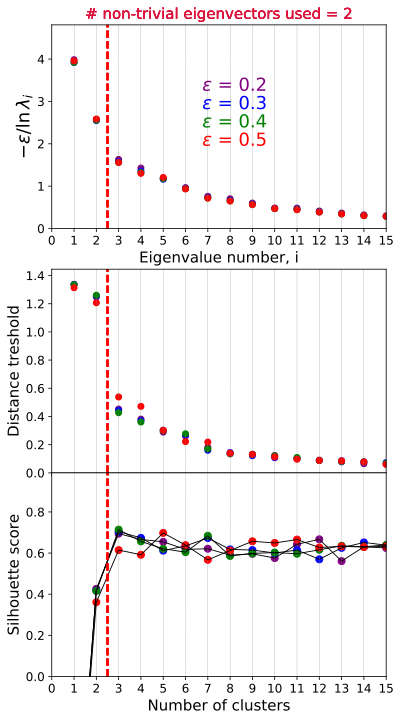

In [7]:
neigen = 3
filename = 'ACTR_0_Sptdmap.npz'
plot_results(filename, neigen, 4, 15, Median = True, Mean = False, Min = False)

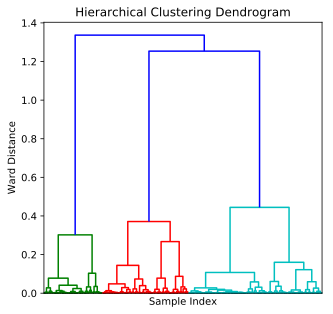

In [8]:
figure(figsize=(5, 5))

filename = 'ACTR_0_Sptdmap.npz'
npzfile = np.load(filename)
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']

neigen = 3
n_eps = 1
X = real(eigenvectors[n_eps,:,1:neigen])

Z = linkage(X, 'ward')

title('Hierarchical Clustering Dendrogram')
xlabel('Sample Index')
ylabel('Ward Distance')
xxx = dendrogram(Z, leaf_rotation=90., leaf_font_size=8., no_labels = True)

In [9]:
filename = 'ACTR_0_Sptdmap.npz'

npzfile = np.load(filename)
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']

n_clusters = 3
neigen = 3

for i in range(1,2):
    print('epsilon = '+str(epsilon[i]))
    X = real(eigenvectors[i,:,1:neigen])
    model_ward, tree_ward = ag_clustering(X, n_clusters)
    #print(model_ward.labels_)
    for k in range(n_clusters):
        idx = np.where(model_ward.labels_ == k)[0]
        print('cluster '+str(k)+' :')
        print(idx)
        

epsilon = 0.3
cluster 0 :
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 

# Simulation under 1M urea

In [10]:
npzfile = np.load('ACTR_1_Sptdmap.npz')
print(npzfile.keys())
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']
#print(np.shape(eigenvectors))
#print(np.shape(epsilon))
#print(np.shape(eigenvalues))

print(epsilon)
print(real(eigenvalues[:,:20]))

['epsilon', 'lambdas', 'eigenvectors']
[0.2 0.3 0.4 0.5 0.6]
[[1.         0.98484903 0.95760946 0.94481392 0.90710219 0.88081301
  0.86815868 0.7810531  0.76584049 0.73647877 0.71476406 0.7021923
  0.61448105 0.58585764 0.55890472 0.54622784 0.50805027 0.47862998
  0.41727109 0.40006677]
 [1.         0.9751291  0.93295639 0.91088404 0.85537671 0.81676818
  0.79667702 0.67588461 0.65559523 0.61563584 0.58561532 0.56776407
  0.46857126 0.43103847 0.3934591  0.38375967 0.33959744 0.31293338
  0.25487206 0.23826847]
 [1.         0.96491081 0.90806891 0.87644426 0.80492608 0.75673501
  0.72861895 0.58496277 0.56163437 0.51546566 0.47851126 0.45736254
  0.35984089 0.31923164 0.28097619 0.27112843 0.23020859 0.2084242
  0.16087538 0.14725706]
 [1.         0.95436798 0.88327497 0.84211308 0.7566915  0.70080717
  0.6647719  0.50761465 0.48216962 0.43311195 0.39117137 0.36855979
  0.27817588 0.23875478 0.2040505  0.19379823 0.15903243 0.14170036
  0.10510758 0.09457373]
 [1.         0.94360915 0

/Users/wangfeiyang/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in divide


epsilon = 0.2
eigenvectors below the treshold = 20
max silhouette score for # clusters = 4 (0.7698920067987409)
epsilon = 0.3
eigenvectors below the treshold = 16
max silhouette score for # clusters = 4 (0.733277294521016)
epsilon = 0.4
eigenvectors below the treshold = 11
max silhouette score for # clusters = 4 (0.742753959794602)
epsilon = 0.5
eigenvectors below the treshold = 12
max silhouette score for # clusters = 4 (0.7540140382477347)


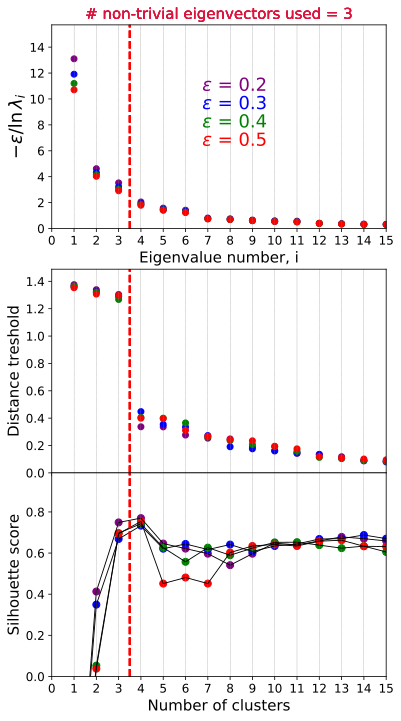

In [11]:
neigen = 4
filename = 'ACTR_1_Sptdmap.npz'
plot_results(filename, neigen, 4, 15, Median = True, Mean = False, Min = False)

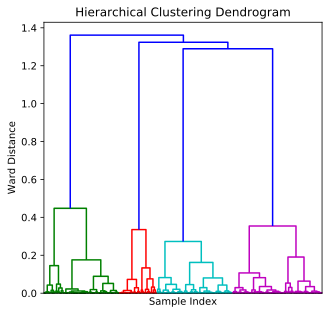

In [12]:
figure(figsize=(5, 5))

filename = 'ACTR_1_Sptdmap.npz'
npzfile = np.load(filename)
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']

neigen = 4
n_eps = 1
X = real(eigenvectors[n_eps,:,1:neigen])

Z = linkage(X, 'ward')

title('Hierarchical Clustering Dendrogram')
xlabel('Sample Index')
ylabel('Ward Distance')
xxx = dendrogram(Z, leaf_rotation=90., leaf_font_size=8., no_labels = True)

In [13]:
filename = 'ACTR_1_Sptdmap.npz'

npzfile = np.load(filename)
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']

n_clusters = 4
neigen = 4

for i in range(1,2):
    print('epsilon = '+str(epsilon[i]))
    X = real(eigenvectors[i,:,1:neigen])
    model_ward, tree_ward = ag_clustering(X, n_clusters)
    #print(model_ward.labels_)
    for k in range(n_clusters):
        idx = np.where(model_ward.labels_ == k)[0]
        print('cluster '+str(k)+' :')
        print(idx)

epsilon = 0.3
cluster 0 :
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501
 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519
 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537
 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555
 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573
 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589]
cluster 1 :
[240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316

# Simulation under 2.5M urea

In [14]:
npzfile = np.load('ACTR_2.5_Sptdmap.npz')
print(npzfile.keys())
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']
#print(np.shape(eigenvectors))
#print(np.shape(epsilon))
#print(np.shape(eigenvalues))

print(epsilon)
print(real(eigenvalues[:,:20]))

['epsilon', 'lambdas', 'eigenvectors']
[0.2 0.3 0.4 0.5 0.6]
[[1.         0.98428898 0.95670867 0.9484882  0.9382209  0.88532771
  0.83540409 0.81870886 0.80185057 0.75580719 0.72784427 0.70025023
  0.64498847 0.58801578 0.56970045 0.55735796 0.52171159 0.4858435
  0.44397703 0.41049095]
 [1.         0.97493486 0.932364   0.9172019  0.90323556 0.82317727
  0.75530075 0.72464314 0.70028979 0.64203888 0.5962812  0.56589695
  0.49903063 0.43380193 0.40939092 0.3924807  0.35292699 0.31763699
  0.27790764 0.24846094]
 [1.         0.96550601 0.9084719  0.88552249 0.868296   0.76437103
  0.68333007 0.6397077  0.60981058 0.54416385 0.48492695 0.45825069
  0.38785368 0.32394455 0.29711766 0.27805479 0.2408808  0.21199165
  0.17836801 0.15493046]
 [1.         0.9561053  0.88520379 0.85397383 0.83358668 0.70935072
  0.61922524 0.5645615  0.53055445 0.46089149 0.39380017 0.37290418
  0.30346811 0.24487753 0.2184715  0.19937687 0.16708272 0.14456679
  0.11773663 0.09987086]
 [1.         0.94678753 

/Users/wangfeiyang/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in divide


epsilon = 0.2
eigenvectors below the treshold = 21
max silhouette score for # clusters = 5 (0.6855769857861176)
epsilon = 0.3
eigenvectors below the treshold = 15
max silhouette score for # clusters = 5 (0.6948668485416595)
epsilon = 0.4
eigenvectors below the treshold = 13
max silhouette score for # clusters = 5 (0.6990254904001116)
epsilon = 0.5
eigenvectors below the treshold = 11
max silhouette score for # clusters = 5 (0.769152249619364)


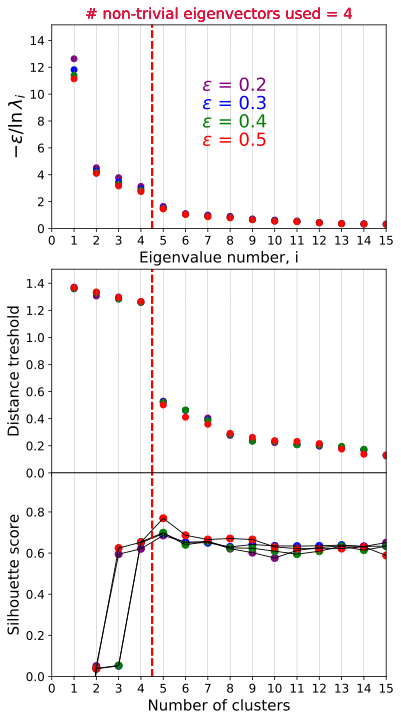

In [15]:
neigen = 5
filename = 'ACTR_2.5_Sptdmap.npz'
plot_results(filename, neigen, 4, 15, Median = True, Mean = False, Min = False)

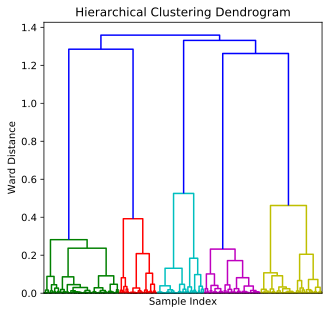

In [16]:
figure(figsize=(5, 5))

filename = 'ACTR_2.5_Sptdmap.npz'
npzfile = np.load(filename)
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']

neigen = 5
n_eps = 1
X = real(eigenvectors[n_eps,:,1:neigen])

Z = linkage(X, 'ward')

title('Hierarchical Clustering Dendrogram')
xlabel('Sample Index')
ylabel('Ward Distance')
xxx = dendrogram(Z, leaf_rotation=90., leaf_font_size=8., no_labels = True)

In [17]:
filename = 'ACTR_2.5_Sptdmap.npz'

npzfile = np.load(filename)
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']

n_clusters = 5
neigen = 5

for i in range(1,2):
    print('epsilon = '+str(epsilon[i]))
    X = real(eigenvectors[i,:,1:neigen])
    model_ward, tree_ward = ag_clustering(X, n_clusters)
    #print(model_ward.labels_)
    for k in range(n_clusters):
        idx = np.where(model_ward.labels_ == k)[0]
        print('cluster '+str(k)+' :')
        print(idx)

epsilon = 0.3
cluster 0 :
[490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543
 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561
 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579
 580 581 582 583 584 585 586 587 588 589]
cluster 1 :
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]
cluster 2 :
[360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 4

# Simulation under 5M urea

In [18]:
npzfile = np.load('ACTR_5_Sptdmap.npz')
print(npzfile.keys())
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']
#print(np.shape(eigenvectors))
#print(np.shape(epsilon))
#print(np.shape(eigenvalues))

print(epsilon)
print(real(eigenvalues[:,:20]))

['epsilon', 'lambdas', 'eigenvectors']
[0.2 0.3 0.4 0.5 0.6]
[[1.         0.98762452 0.96836984 0.95639885 0.94017554 0.91791672
  0.88418389 0.84341791 0.81571324 0.78796282 0.75682545 0.74103728
  0.68277173 0.64191639 0.59246634 0.58169452 0.55410172 0.52813518
  0.46145444 0.44577403]
 [1.         0.97990264 0.94884604 0.9299445  0.90420283 0.86903553
  0.81722839 0.7574669  0.71943356 0.67997772 0.63508935 0.61387978
  0.54012236 0.49016004 0.43109493 0.41683328 0.3843722  0.35837825
  0.29827393 0.27599185]
 [1.         0.97194114 0.92892859 0.90309464 0.86805629 0.8206291
  0.75238646 0.67799866 0.63290011 0.5847666  0.53015065 0.50534292
  0.42707915 0.37427986 0.31638469 0.30034193 0.26762843 0.24533619
  0.19683398 0.17484441]
 [1.         0.96387233 0.9090253  0.87619451 0.83207655 0.7733501
  0.69075932 0.60596127 0.55630119 0.50208704 0.4418161  0.41461455
  0.33852099 0.28693807 0.23482841 0.21860201 0.18864575 0.17034701
  0.13286226 0.11415719]
 [1.         0.95576975 0

epsilon = 0.2
eigenvectors below the treshold = 23
max silhouette score for # clusters = 6 (0.6642530624425332)
epsilon = 0.3
eigenvectors below the treshold = 17
max silhouette score for # clusters = 13 (0.67361175953857)
epsilon = 0.4
eigenvectors below the treshold = 13
max silhouette score for # clusters = 6 (0.6938469053085385)
epsilon = 0.5
eigenvectors below the treshold = 11
max silhouette score for # clusters = 6 (0.6594290164086445)


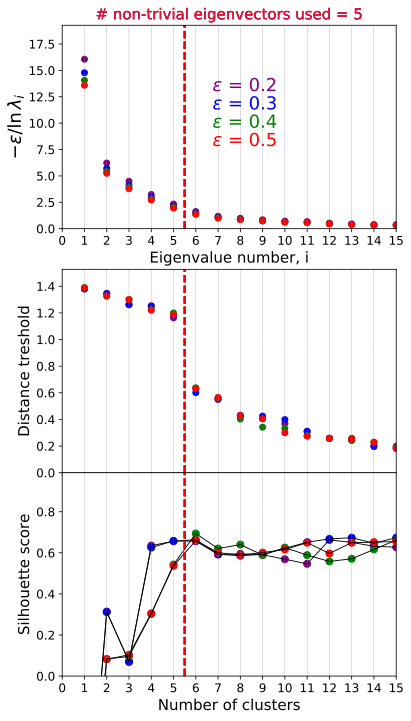

In [19]:
neigen = 6
filename = 'ACTR_5_Sptdmap.npz'
plot_results(filename, neigen, 4, 15, Median = True, Mean = False, Min = False)

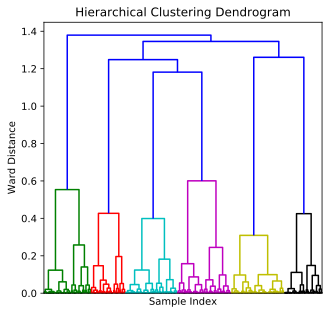

In [20]:
figure(figsize=(5, 5))

filename = 'ACTR_5_Sptdmap.npz'
npzfile = np.load(filename)
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']

neigen = 6
n_eps = 1
X = real(eigenvectors[n_eps,:,1:neigen])

Z = linkage(X, 'ward')

title('Hierarchical Clustering Dendrogram')
xlabel('Sample Index')
ylabel('Ward Distance')
xxx = dendrogram(Z, leaf_rotation=90., leaf_font_size=8., no_labels = True)

In [21]:
filename = 'ACTR_5_Sptdmap.npz'

npzfile = np.load(filename)
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']

n_clusters = 6
neigen = 6

for i in range(1,2):
    print('epsilon = '+str(epsilon[i]))
    X = real(eigenvectors[i,:,1:neigen])
    model_ward, tree_ward = ag_clustering(X, n_clusters)
    #print(model_ward.labels_)
    for k in range(n_clusters):
        idx = np.where(model_ward.labels_ == k)[0]
        print('cluster '+str(k)+' :')
        print(idx)

epsilon = 0.3
cluster 0 :
[303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320
 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338
 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374
 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410
 411 412 413 414 415 416]
cluster 1 :
[490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543
 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561
 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579
 580 581 582 583 584 585 586 587 588 589]
cluster 2 :
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25

# Simulation under 7M urea

In [22]:
npzfile = np.load('ACTR_7_Sptdmap.npz')
print(npzfile.keys())
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']
#print(np.shape(eigenvectors))
#print(np.shape(epsilon))
#print(np.shape(eigenvalues))

print(epsilon)
print(real(eigenvalues[:,:20]))

['epsilon', 'lambdas', 'eigenvectors']
[0.2 0.3 0.4 0.5 0.6]
[[1.         0.99555251 0.98244307 0.96643923 0.95583976 0.91933664
  0.89092854 0.84230721 0.82690804 0.79654395 0.74398225 0.72566594
  0.67989582 0.61458769 0.58977275 0.57962851 0.55633457 0.51222271
  0.47094091 0.42767342]
 [1.         0.99239358 0.97049315 0.94429269 0.927126   0.87066486
  0.82658736 0.75311392 0.73173258 0.68867982 0.6198705  0.59215787
  0.53542058 0.45831689 0.42593799 0.41383097 0.38649708 0.3410301
  0.29927402 0.26148476]
 [1.         0.98888598 0.95749902 0.92107262 0.89750304 0.8220082
  0.76366929 0.6699895  0.64343246 0.59271335 0.51340597 0.48158563
  0.42081922 0.34300644 0.30970998 0.29711683 0.26953495 0.22926835
  0.19467079 0.16520805]
 [1.         0.98508441 0.94370435 0.89717621 0.86738291 0.77430939
  0.70331447 0.59470681 0.56399307 0.50920335 0.42410066 0.39230717
  0.33144216 0.258975   0.22820234 0.21590888 0.19046521 0.15707657
  0.13061678 0.1082056 ]
 [1.         0.9810299  0

epsilon = 0.2
eigenvectors below the treshold = 22
max silhouette score for # clusters = 5 (0.7481136443748303)
epsilon = 0.3
eigenvectors below the treshold = 17
max silhouette score for # clusters = 5 (0.7645078751747385)
epsilon = 0.4
eigenvectors below the treshold = 12
max silhouette score for # clusters = 5 (0.7739987148174589)
epsilon = 0.5
eigenvectors below the treshold = 11
max silhouette score for # clusters = 5 (0.7729186831565713)


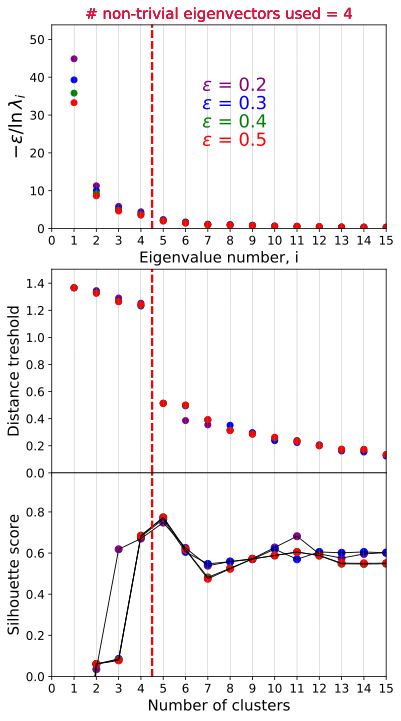

In [23]:
neigen = 5
filename = 'ACTR_7_Sptdmap.npz'
plot_results(filename, neigen, 4, 15, Median = True, Mean = False, Min = False)

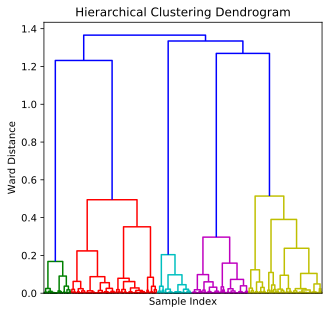

In [24]:
figure(figsize=(5, 5))

filename = 'ACTR_7_Sptdmap.npz'
npzfile = np.load(filename)
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']

neigen = 5
n_eps = 1
X = real(eigenvectors[n_eps,:,1:neigen])

Z = linkage(X, 'ward')

title('Hierarchical Clustering Dendrogram')
xlabel('Sample Index')
ylabel('Ward Distance')
xxx = dendrogram(Z, leaf_rotation=90., leaf_font_size=8., no_labels = True)

In [25]:
filename = 'ACTR_7_Sptdmap.npz'

npzfile = np.load(filename)
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']

n_clusters = 5
neigen = 5

for i in range(1,2):
    print('epsilon = '+str(epsilon[i]))
    X = real(eigenvectors[i,:,1:neigen])
    model_ward, tree_ward = ag_clustering(X, n_clusters)
    #print(model_ward.labels_)
    for k in range(n_clusters):
        idx = np.where(model_ward.labels_ == k)[0]
        print('cluster '+str(k)+' :')
        print(idx)

epsilon = 0.3
cluster 0 :
[360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515]
cluster 1 :
[ 58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138

# Simulation under 9M urea

In [26]:
npzfile = np.load('ACTR_9_Sptdmap.npz')
print(npzfile.keys())
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']
#print(np.shape(eigenvectors))
#print(np.shape(epsilon))
#print(np.shape(eigenvalues))

print(epsilon)
print(real(eigenvalues[:,:20]))

['epsilon', 'lambdas', 'eigenvectors']
[0.2 0.3 0.4 0.5 0.6]
[[1.         0.99367929 0.97900551 0.96615629 0.94416725 0.92419421
  0.88574663 0.84689824 0.82749738 0.79907332 0.75845833 0.74170015
  0.70113083 0.64736011 0.61716417 0.57830553 0.55387662 0.51701186
  0.49322586 0.465589  ]
 [1.         0.98912787 0.96481639 0.94433133 0.90953755 0.87803907
  0.82055782 0.76314125 0.73362593 0.69444229 0.63704155 0.61369579
  0.56181623 0.49459648 0.45825147 0.40827765 0.38577175 0.35108198
  0.32313815 0.29146725]
 [1.         0.98409632 0.94959326 0.9214417  0.87471598 0.83176435
  0.75786113 0.68535787 0.64751535 0.60125102 0.53302614 0.50501633
  0.44846826 0.37750633 0.34026229 0.29177731 0.27046204 0.24027015
  0.2136467  0.18555392]
 [1.         0.97874248 0.93377378 0.89788606 0.8402062  0.78617318
  0.69839832 0.61462993 0.57043008 0.5197453  0.44583656 0.41476785
  0.35785635 0.289165   0.25388262 0.21189343 0.19167404 0.16662927
  0.14375411 0.12122261]
 [1.         0.97317075

epsilon = 0.2
eigenvectors below the treshold = 23
max silhouette score for # clusters = 4 (0.714675730988406)
epsilon = 0.3
eigenvectors below the treshold = 16
max silhouette score for # clusters = 4 (0.750198155053299)
epsilon = 0.4
eigenvectors below the treshold = 14
max silhouette score for # clusters = 4 (0.7499597019786393)
epsilon = 0.5
eigenvectors below the treshold = 11
max silhouette score for # clusters = 4 (0.7193847867612506)


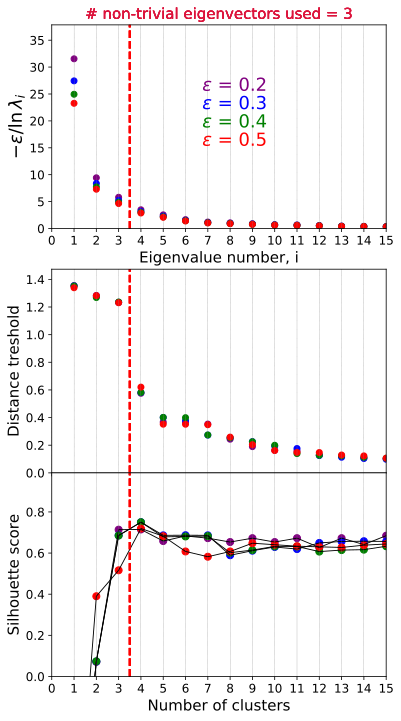

In [27]:
neigen = 4
filename = 'ACTR_9_Sptdmap.npz'
plot_results(filename, neigen, 4, 15, Median = True, Mean = False, Min = False)

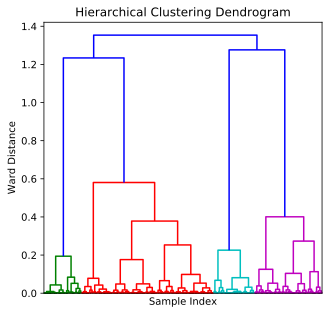

In [28]:
figure(figsize=(5, 5))

filename = 'ACTR_9_Sptdmap.npz'
npzfile = np.load(filename)
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']

neigen = 4
n_eps = 1
X = real(eigenvectors[n_eps,:,1:neigen])

Z = linkage(X, 'ward')

title('Hierarchical Clustering Dendrogram')
xlabel('Sample Index')
ylabel('Ward Distance')
xxx = dendrogram(Z, leaf_rotation=90., leaf_font_size=8., no_labels = True)

In [29]:
filename = 'ACTR_9_Sptdmap.npz'

npzfile = np.load(filename)
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['lambdas']

n_clusters = 4
neigen = 4

for i in range(1,2):
    print('epsilon = '+str(epsilon[i]))
    X = real(eigenvectors[i,:,1:neigen])
    model_ward, tree_ward = ag_clustering(X, n_clusters)
    #print(model_ward.labels_)
    for k in range(n_clusters):
        idx = np.where(model_ward.labels_ == k)[0]
        print('cluster '+str(k)+' :')
        print(idx)

epsilon = 0.3
cluster 0 :
[ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295
 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 